In [24]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone.core.labels import Detection

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data

import torchvision
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

import matplotlib.pyplot as plt

import cv2

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

import os
import importlib

import utils
import train
from train import train_one_epoch, evaluate
import transforms
import DatasetLoaders
importlib.reload(DatasetLoaders)
from DatasetLoaders import HRSIDDataset

/tmp/ipykernel_58903/3484137123.py:21: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_58903/3484137123.py:22: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


Implementing land masking with process from this paper [Ship detection in SAR images using efficient land masking methods](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/9093/1/Ship-detection-in-SAR-images-using-efficient-land-masking-methods/10.1117/12.2053171.short?SSO=1)


In [3]:
# Loading Dataset
name = "HRSID"
if name in fo.list_datasets():
    dataset_traintest = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_traintest = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
    )

 100% |███████████████| 5604/5604 [32.7s elapsed, 0s remaining, 161.4 samples/s]      


In [4]:
session = fo.launch_app()

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port


In [5]:
img_paths = dataset_traintest.values("filepath")

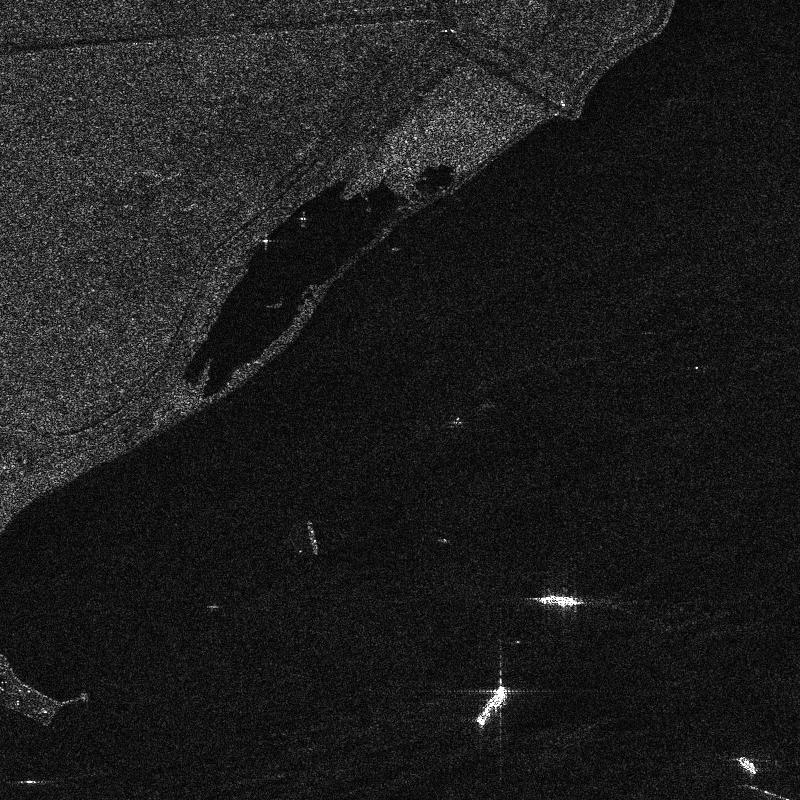

In [16]:
img1 = Image.open(img_paths[2]).convert("RGB")
img1.show()

In [55]:
def lee_filter3(img, size):
    img_mean = uniform_filter(img, (size, size, 3))
    img_sqr_mean = uniform_filter(img**2, (size, size, 3))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def lee_filter1(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [57]:
np.unique(np.array(img1))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [63]:
np.unique(lee_filter3(np.array(img1)/255, 5))


array([0.02293821, 0.02536876, 0.02621077, ..., 0.98440889, 0.98446376,
       0.98480873])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


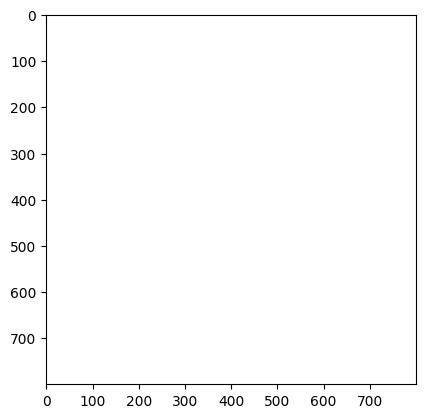

In [60]:
plt.imshow(lee_filter3(np.array(img1), 5))

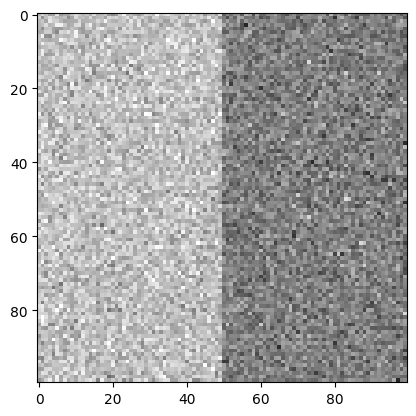

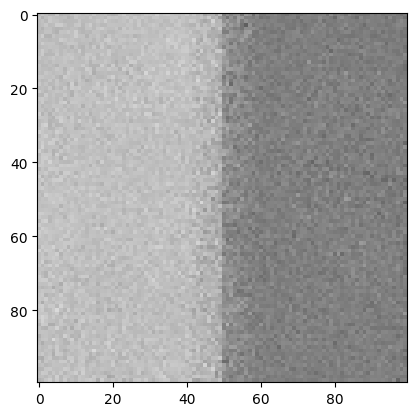

In [53]:
img = np.random.normal(0.5, 0.1, (100,100))
img[:,:50] += 0.25
plt.imshow(img, vmin=0, vmax=1, cmap='gray')
plt.figure()
plt.imshow(lee_filter1(img, 20), vmin=0, vmax=1, cmap='gray')

In [62]:
np.unique(img)

array([0.14931313, 0.15255826, 0.16383405, ..., 1.05823434, 1.07195973,
       1.08650733])